In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import glob
import os
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self):
        self.imgs_path = "/Users/tinghui/workspace/python/dtu_mlops/data/corruptmnist/"
        
        image = glob.glob(self.imgs_path + "*train_image*")
        # label = glob.glob(self.imgs_path + "*train_target*")
        self.data = []
        self.labels = []
        for image_path in image:
            
            root,tail = os.path.split(image_path)
            label_path = os.path.join(root, tail.split("_")[0]+"_target_"+tail.split("_")[-1])

            loaded_data = torch.load(image_path)
            loaded_labels = torch.load(label_path)
            
            assert len(loaded_data) == len(loaded_labels)
            
            self.data.extend(loaded_data)
            self.labels.extend(loaded_labels)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # Add other transformations as needed
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {
            'data': self.data[idx],
            'label': self.labels[idx]
        }

        # Apply transformations if needed
        if self.transform:
            if not isinstance(sample['data'], torch.Tensor):
                sample['data'] = self.transform(sample['data'])

        return sample

class TestDataset(Dataset):
    def __init__(self):
        self.imgs_path = "/Users/tinghui/workspace/python/dtu_mlops/data/corruptmnist/"
        
        image_path = os.path.join(self.imgs_path, "test_images.pt")
        label_path = os.path.join(self.imgs_path, "test_target.pt")
        
        self.data =  torch.load(image_path)
        self.labels =  torch.load(label_path)

        assert len(self.data) == len(self.labels)

        # You may need to preprocess the data or apply transformations here
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # Add other transformations as needed
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {
            'data': self.data[idx],
            'label': self.labels[idx]
        }

        # Apply transformations if needed
        if self.transform:
            if not isinstance(sample['data'], torch.Tensor):
                sample['data'] = self.transform(sample['data'])

        return sample


def mnist():
    """Return train and test dataloaders for MNIST."""
    # exchange with the corrupted mnist dataset
    trainset = TrainDataset()
    testset= TestDataset()
    batch_size = 64  # Adjust this based on your requirements
    shuffle = True    # You may want to shuffle the data during training
    train = DataLoader(trainset, batch_size=batch_size, shuffle=shuffle)
    test = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train, test


In [5]:
from torch import nn
import torch.nn.functional as F

class MyAwesomeModel(nn.Module):
    """My awesome model."""

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        #Dropout with 0.2 probability
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x


In [9]:
def validation(model, testloader, criterion):
    """Validate the model on the testdata by calculating the sum of mean loss and mean accuracy for each test batch.

    Arguments:
        model: torch network
        testloader: torch.utils.data.DataLoader, dataloader of test set
        criterion: loss function
    """
    accuracy = 0
    test_loss = 0
    for batch in testloader:

        # load data and labels in the batch
        data = batch['data']
        labels = batch['label']

        output = model.forward(data)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = labels.data == ps.max(1)[1]
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy

In [16]:
from torch import optim
lr = 1e-4





model = MyAwesomeModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 30
steps = 0
running_loss = 0

train_set, test_set = mnist()


train_losses, test_losses = [], []

for e in range(epochs):
    for batch in train_set:
        steps += 1
        # load data and labels in the batch
        data = batch['data']
        labels = batch['label']

        # Training
        optimizer.zero_grad()
        log_ps = model(data)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
         
    else:
        model.eval()

        # Turn off gradients for validation, will speed up inference
        with torch.no_grad():
            test_loss, accuracy = validation(model, test_set, criterion)

        train_loss = running_loss/len(train_set)
        train_losses.append(train_loss)
        test_loss = test_loss / len(test_set)
        test_losses.append(test_loss)
        print(
            "Epoch: {}/{} ".format(e + 1, epochs),
            "Training Loss: {:.3f} ".format(train_loss),
            "Test Loss: {:.3f} ".format(test_loss),
            "Test Accuracy: {:.3f}".format(accuracy / len(test_set)),
            )
        running_loss = 0
        model.train()

torch.save(model.state_dict(), 'trained_model.pt')

Epoch: 1/30  Training Loss: 1.656  Test Loss: 0.909  Test Accuracy: 0.749
Epoch: 2/30  Training Loss: 0.936  Test Loss: 0.678  Test Accuracy: 0.800
Epoch: 3/30  Training Loss: 0.772  Test Loss: 0.584  Test Accuracy: 0.825
Epoch: 4/30  Training Loss: 0.671  Test Loss: 0.517  Test Accuracy: 0.842
Epoch: 5/30  Training Loss: 0.600  Test Loss: 0.465  Test Accuracy: 0.857
Epoch: 6/30  Training Loss: 0.533  Test Loss: 0.432  Test Accuracy: 0.866
Epoch: 7/30  Training Loss: 0.488  Test Loss: 0.390  Test Accuracy: 0.879
Epoch: 8/30  Training Loss: 0.451  Test Loss: 0.368  Test Accuracy: 0.888
Epoch: 9/30  Training Loss: 0.413  Test Loss: 0.348  Test Accuracy: 0.894
Epoch: 10/30  Training Loss: 0.386  Test Loss: 0.325  Test Accuracy: 0.900
Epoch: 11/30  Training Loss: 0.358  Test Loss: 0.313  Test Accuracy: 0.902
Epoch: 12/30  Training Loss: 0.337  Test Loss: 0.304  Test Accuracy: 0.903
Epoch: 13/30  Training Loss: 0.315  Test Loss: 0.287  Test Accuracy: 0.907
Epoch: 14/30  Training Loss: 0.295

In [17]:
model = MyAwesomeModel()
state_dict = torch.load('trained_model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
_, accuracy = validation(model, test_set,criterion)
print(accuracy / len(test_set))

tensor(0.9173)


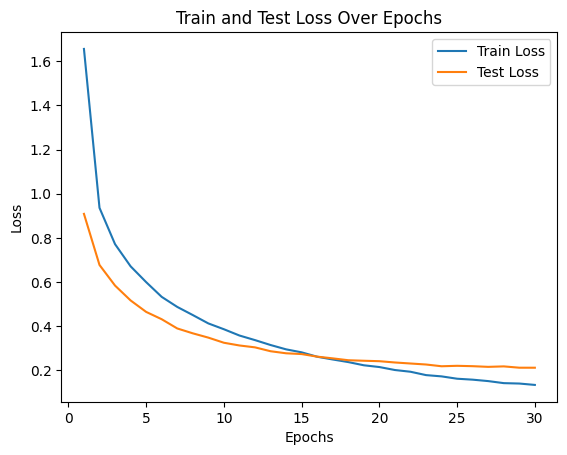

In [19]:
import matplotlib.pyplot as plt


epochs = range(1, len(train_losses) + 1)

# Plotting train and test losses
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')

plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [20]:
def evaluate(model_checkpoint):
    """Evaluate a trained model."""
    print("Evaluating like my life dependends on it")
    print(model_checkpoint)



    # TODO: Implement evaluation logic here
    model = MyAwesomeModel()
    state_dict = torch.load(model_checkpoint)
    model.load_state_dict(state_dict)  
     
    _, test_set = mnist()
    criterion = nn.CrossEntropyLoss()
    _, accuracy = validation(model, test_set,criterion)
    print("Accuracy: {:.3f}".format(accuracy / len(test_set)))

In [21]:

evaluate('trained_model.pt')

Evaluating like my life dependends on it
trained_model.pt
Accuracy: 0.913
